22BAI1173\
25/02/2025\
Lab 7\
L39+L40\
chatgpt: https://chatgpt.com/share/67bdac5f-73c8-8004-8f16-01dc9524c297

# Question 1 - Super pixel-Guided Graph Segmentation for Real-Time Video Processing
  • Implement a superpixel-based graph segmentation algorithm that processes video frames in real time. Use an optimized graph structure to reduce computational overhead. /
  • Implement region-growing segmentation by selecting a seed point and expanding based on similarity criteria. Modify region growing to automatically select multiple seeds based on edge detection.

In [36]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.graph import rag_mean_color
from skimage.color import label2rgb
from skimage.filters import sobel

In [37]:
def superpixel_graph_segmentation(frame, n_segments=100):
    """Applies superpixel-based graph segmentation using RAG."""
    lab_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    segments = slic(lab_frame, n_segments=n_segments, compactness=10, sigma=1, start_label=1)
    rag = rag_mean_color(frame, segments, mode='similarity')
    segmented_image = label2rgb(segments, frame, kind='avg')
    return segmented_image.astype(np.uint8)

In [38]:
def auto_region_growing(frame):
    """Performs region growing segmentation with automatic seed selection."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = sobel(gray)
    seeds = np.argwhere(edges > np.percentile(edges, 90))
    mask = np.zeros((gray.shape[0] + 2, gray.shape[1] + 2), dtype=np.uint8)

    for seed in seeds:
        cv2.floodFill(frame, mask, tuple(seed[::-1]), 255, loDiff=10, upDiff=10, flags=8)

    return frame

In [40]:
def region_growing_segmentation(frame, edge_thresh=50, lo_diff=20, up_diff=20):
    """Performs region growing segmentation with automatic seed selection using edge detection."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, edge_thresh, edge_thresh * 2)

    # Seed selection using grid and edges
    h, w = gray.shape
    seeds = []
    for i in range(0, h, 10):  # Sample every 10 pixels
        for j in range(0, w, 10):
            if edges[i, j] > 0 or np.random.rand() < 0.01:  # Add edge points and random points
                seeds.append([i, j])

    segmented = np.zeros_like(gray)
    mask = np.zeros((gray.shape[0] + 2, gray.shape[1] + 2), np.uint8)

    for seed in seeds:
        if segmented[seed[0], seed[1]] == 0:
            cv2.floodFill(segmented, mask, tuple(seed[::-1]), 255, loDiff=lo_diff, upDiff=up_diff, flags=cv2.FLOODFILL_MASK_ONLY)

    return segmented

In [50]:
video_path = "video.mp4"
cap = cv2.VideoCapture(video_path)

In [51]:
count = 0
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if count % 24 == 0:
        segmented_frame = superpixel_graph_segmentation(frame)
        region_growing_frame = auto_region_growing(frame.copy())
        frames.append((segmented_frame, region_growing_frame))

    count += 1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

In [53]:
fig, axes = plt.subplots(len(frames), 2, figsize=(10, 5 * len(frames)))
for i, (seg, reg) in enumerate(frames):
    axes[i, 0].imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(f"Superpixel Segmentation - Frame {i * 10}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cv2.cvtColor(reg, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title(f"Region Growing Segmentation - Frame {i * 10}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Question 2 - Multi-Scale Morphological Skeletonization for Object Shape Analysis

Implement multi-scale morphological skeletonization for shape feature extraction and analyze its effectiveness in real-world images.

1. Preprocessing \
  ◦ Convert images to grayscale and apply adaptive thresholding. \
  ◦ Perform noise reduction using morphological opening. \
2. Morphological Skeletonization \
  ◦ Implement a multi-scale skeletonization method.  
  ◦ Apply thinning iteratively until a single-pixel skeleton is obtained.
3. Feature Extraction \
  ◦ Extract shape descriptors (elongation, convexity, and circularity) from skeletonized objects.
4. Comparison with Traditional Edge Detection \
  ◦ Compare results with Canny and Sobel edge detection. \
  ◦ Analyze effectiveness using IoU and boundary accuracy metrics.

In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, opening, square
from skimage.filters import sobel
from skimage.metrics import adapted_rand_error
import pandas as pd

In [83]:
image_path = "image.jpg"
image = cv2.imread(image_path)

In [96]:
def preprocess_image(image):
    """Converts image to grayscale, applies adaptive thresholding, and performs noise reduction."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    noise_reduced = opening(thresh, square(3))
    return noise_reduced

In [97]:
def morphological_skeletonization(image):
    """Applies multi-scale skeletonization using iterative thinning."""
    skeleton = skeletonize(preprocessed // 255) * 255
    return skeleton.astype(np.uint8)

In [92]:
def extract_shape_descriptors(skeleton):
    """Extracts elongation, convexity, and circularity from skeletonized objects."""
    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    descriptors = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)

        if area == 0 or perimeter == 0 or hull_area == 0:
            continue

        elongation = perimeter ** 2 / (4 * np.pi * area)
        convexity = hull_area / area
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        descriptors.append({"elongation": elongation, "convexity": convexity, "circularity": circularity})

    return descriptors

In [100]:
def compare_with_edge_detection(image):
    """Compares skeletonization with traditional edge detection methods."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    canny_edges = cv2.Canny(gray, 100, 200)
    sobel_edges = sobel(gray)
    skeleton = morphological_skeletonization(image)

    # Convert sobel_edges to binary before calculating metrics
    sobel_edges_binary = (sobel_edges > 0).astype(np.uint8)  # Threshold to create binary image

    # Compute IoU and boundary accuracy metrics using the binary sobel_edges
    iou_canny = adapted_rand_error(skeleton, canny_edges)[0]
    iou_sobel = adapted_rand_error(skeleton, sobel_edges_binary)[0]  # Use binary sobel_edges

    metrics = {"IoU Canny": iou_canny, "IoU Sobel": iou_sobel}

    return canny_edges, sobel_edges, skeleton, metrics

In [101]:
skeleton = morphological_skeletonization(image)
descriptors = extract_shape_descriptors(skeleton)
canny_edges, sobel_edges, skeleton, metrics = compare_with_edge_detection(image)

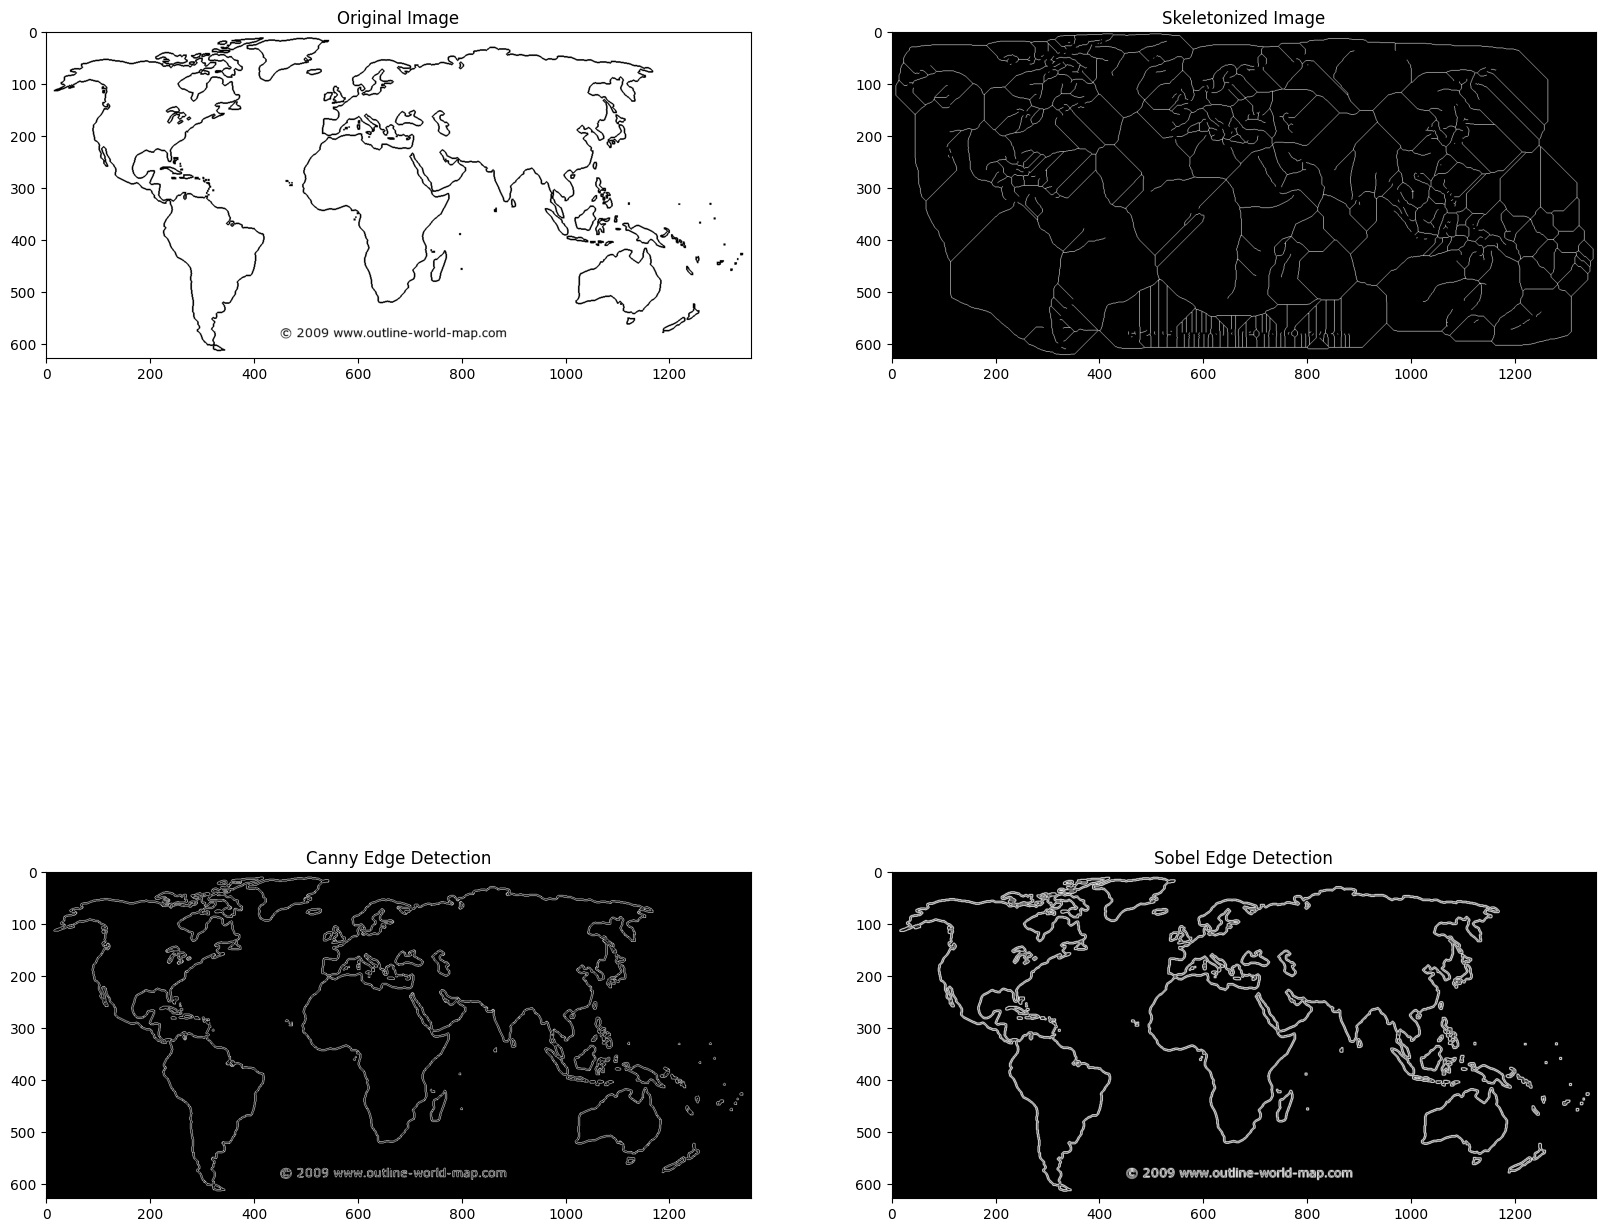

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes[0][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0][0].set_title("Original Image")
axes[0][1].imshow(skeleton, cmap='gray')
axes[0][1].set_title("Skeletonized Image")
axes[1][0].imshow(canny_edges, cmap='gray')
axes[1][0].set_title("Canny Edge Detection")
axes[1][1].imshow(sobel_edges, cmap='gray')
axes[1][1].set_title("Sobel Edge Detection")
plt.show()

In [103]:
descriptors_df = pd.DataFrame(descriptors)
print("Shape Descriptors:")
display(descriptors_df)

Shape Descriptors:


,elongation,convexity,circularity
0,1.559131,1.042301,0.641383


In [104]:
metrics_df = pd.DataFrame([metrics])
print("Comparison Metrics:")
display(metrics_df)

Comparison Metrics:


,IoU Canny,IoU Sobel
0,0.000223,0.010878
